# ¿Cuál es un mejor plan?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats

## Cargar los datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames

users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')

## Preparar los datos

A continuación exploraremos cada tabla para poder comprender bien cada una de ellas y si es necesario hacer correcciones.

## Planes

In [3]:
# Imprime la información general/resumen sobre el DataFrame de los planes

plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


Observamos información sobre los dos planes de tarifa ofrecidos. Cada fila representa un plan y sus respectivos atributos, como los minutos, mensajes SMS y volumen de datos incluidos en el plan, el pago mensual, los precios por gb de datos, mensaje SMS y minuto de llamada adicionales, y el nombre del plan. No se encuentran valores nulos en estos datos.

In [4]:
# Imprime una muestra de los datos para los planes

plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


 El plan "surf" tiene una tarifa mensual de 20 USD e incluye 50 mensajes, 15360 megabytes y 500 minutos. Además, se aplican cargos adicionales por uso excesivo. Por otro lado, el plan "ultimate" tiene una tarifa mensual de 70 USD y ofrece una mayor asignación de 1000 mensajes, 30720 megabytes y 3000 minutos, con costos adicionales más bajos. 

## Corregir los datos

Convertiremos las tarifas y costos a tipos de datos float para cálculos más precisos en el análisis.

In [5]:
cost_columns = ['usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute']
plans[cost_columns] = plans[cost_columns].astype(float)

In [6]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20.0,10.0,0.03,0.03,surf
1,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate


## Enriquecer los datos

Podríamos fusionar la info de 'users' para ver qué plan tiene cada usuario.

In [7]:
# Fusionar los datos de planes y usuarios
users.merge(plans, left_on='plan', right_on='plan_name', how='inner')

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate
1,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate
2,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate
3,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate
4,1013,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,ultimate,NaN,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1494,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,NaN,50,15360,500,20.0,10.0,0.03,0.03,surf
496,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN,50,15360,500,20.0,10.0,0.03,0.03,surf
497,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN,50,15360,500,20.0,10.0,0.03,0.03,surf
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN,50,15360,500,20.0,10.0,0.03,0.03,surf


También podríamos sumar las llamadas por plan y fusionar la infomración con 'plans'.

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['month'] = calls['call_date'].dt.month


# Fusiona los DataFrames users y plans en base a la columna 'plan'
user_mensual_data = users.merge(plans, left_on='plan', right_on='plan_name', how='inner')

# Convierte la columna de fecha de registro a tipo datetime
user_mensual_data['reg_date'] = pd.to_datetime(user_mensual_data['reg_date'])

# Calcula la cantidad de llamadas hechas por cada usuario en cada mes
calls['call_date'] = pd.to_datetime(calls['call_date'])
call_duration_by_plan_month = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()

# Fusiona la información de las llamadas con el DataFrame user_mensual_data
user_mensual_data = user_mensual_data.merge(call_duration_by_plan_month, on='user_id', how='left')

# Renombra la columna para que sea más descriptiva
user_mensual_data.rename(columns={'duration': 'total_call_duration'}, inplace=True)


calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


In [9]:
# Calcula la suma de llamadas por plan
call_duration_by_plan = user_mensual_data.groupby('plan')['total_call_duration'].sum().reset_index()

# Renombra la columna para que sea más descriptiva
call_duration_by_plan.rename(columns={'total_call_duration': 'total_calls'}, inplace=True)

# Fusiona la información con el DataFrame 'plans'
plans = plans.merge(call_duration_by_plan, left_on='plan_name', right_on='plan', how='left')

# Elimina la columna duplicada de 'plan'
plans.drop(columns='plan', inplace=True)


In [10]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total_calls
0,50,15360,500,20.0,10.0,0.03,0.03,surf,636691.24
1,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate,292459.02


## Usuarios

In [11]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Vemos que hay un total de 500 registros que representan a los usuarios. La mayoría de las columnas son de tipo object (texto), excepto por las columnas "user_id" y "age". La columna "reg_date" muestra la fecha de suscripción de cada usuario, mientras que la columna "churn_date" tiene valores no nulos en solo 34 filas, lo que sugiere que un número limitado de usuarios ha dejado de utilizar el servicio.

In [12]:
# Imprime una muestra de los datos para los usuarios

users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Observamos que hay usuarios de diferentes edades y ciudades, suscribiéndose a los planes "surf" o "ultimate". La mayoría no tiene fecha de cancelación, lo que indica que siguen utilizando el servicio. 

**Problemas identificados**

- Valores Faltantes: La columna "churn_date" tiene valores nulos en la mayoría de las filas, lo que indica que la mayoría de los usuarios no han cancelado su suscripción. Podríamos reemplazar los valores nulos con "No cancelado" para indicar que los usuarios no han cancelado.
- Formato de Fechas: Las columnas "reg_date" y "churn_date" deberían convertirse a tipos de datos de fecha y hora.

### Corregir datos

In [13]:
# Convertimos las columnas "reg_date" y "churn_date" al formato de fecha y hora
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'], errors='coerce')

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [15]:
#Reemplazamos valores nulos con 'No cancelado'
users['churn_date'].fillna('No cancelado', inplace=True)

In [16]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,No cancelado
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,No cancelado
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,No cancelado
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,No cancelado
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,No cancelado


### Enriquecer datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [17]:
# Extraer el mes de registro
users['reg_month'] = users['reg_date'].dt.month

In [18]:
# Categorizar la edad en grupos
def categorize_age(age):
    if age < 18:
        return 'Niño'
    elif age >= 18 and age < 40:
        return 'Joven'
    elif age >= 41 and age < 60:
        return 'Adulto'
    else:
        return 'Mayor'

users['age_group'] = users['age'].apply(categorize_age)


In [19]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,age_group
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,No cancelado,12,Adulto
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,No cancelado,8,Joven
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,No cancelado,10,Joven
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,No cancelado,1,Adulto
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,No cancelado,5,Mayor


In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
 8   reg_month   500 non-null    int64         
 9   age_group   500 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 39.2+ KB


churn_date volvió a ser del tipo object.

## Llamadas

In [21]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.3+ MB


Vemos datos sobre las llamadas realizadas por los usuarios. Cada fila representa una llamada y contiene información como el identificador de la llamada ("id"), el identificador del usuario que realizó la llamada ("user_id"), la fecha de la llamada ("call_date") y la duración de la llamada en minutos ("duration"). 

In [22]:
# Imprime una muestra de datos para llamadas
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


Estos datos permiten explorar la duración promedio de las llamadas, patrones temporales en el uso y posibles diferencias en la duración según el usuario o el plan de tarifa.

**Problemas identificados**
- Formato de fechas: La columna "call_date" actualmente está en formato de objeto y debería convertirse a un tipo de dato de fecha y hora para un análisis temporal más preciso. 

### Corregir datos

In [23]:
# Convertimos la columna "call_date" al formato de fecha y hora
calls['call_date'] = pd.to_datetime(calls['call_date'])


In [24]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.3+ MB


### Enriquecer datos

Agregaremos una columna para el día de la semana.

In [25]:
# Agregar una columna para el día de la semana de la llamada
calls['day_of_week'] = calls['call_date'].dt.day_name()

In [26]:
calls.head()

,id,user_id,call_date,duration,month,day_of_week
0,1000_93,1000,2018-12-27,8.52,12,Thursday
1,1000_145,1000,2018-12-27,13.66,12,Thursday
2,1000_247,1000,2018-12-27,14.48,12,Thursday
3,1000_309,1000,2018-12-28,5.76,12,Friday
4,1000_380,1000,2018-12-30,4.22,12,Sunday


## Mensajes

In [27]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Tenemos información sobre los mensajes enviados por los usuarios, con columnas que incluyen el identificador único del mensaje ("id"), el identificador del usuario que envió el mensaje ("user_id") y la fecha en que se envió el mensaje ("message_date"). 

In [28]:
# Imprime una muestra de datos para los mensajes
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Información sobre mensajes enviados por usuarios, incluyendo el identificador único del mensaje, el identificador del usuario que lo envió y la fecha en que se envió el mensaje. 

**Problemas identificados**
- Formato de fechas: La columna "message_date" actualmente está en formato de objeto y debería convertirse a un tipo de dato de fecha y hora para un análisis temporal más preciso. 

### Corregir datos

In [29]:
# Convertir la columna "message_date" al formato de fecha y hora
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [30]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer datos

Sumaremos una columna que indique el mes en que se envió cada mensaje.

In [31]:
# Agregar una columna para el mes en que se envió el mensaje
messages['month'] = messages['message_date'].dt.month

In [32]:
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [33]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


Contiene información sobre sesiones web de los usuarios, con columnas que incluyen el identificador único de la sesión ("id"), el identificador del usuario que realizó la sesión ("user_id"), la fecha de la sesión ("session_date") y el volumen de datos utilizado en megabytes ("mb_used").

In [34]:
# Imprime una muestra de datos para el tráfico de internet
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Información sobre las sesiones web realizadas por los usuarios, con columnas que contienen el identificador único de la sesión, el identificador del usuario que realizó la sesión, la fecha de la sesión y el volumen de datos utilizado en megabytes. 

**Problemas identificados**
- Formato de fechas: La columna "session_date" actualmente está en formato de objeto y debería convertirse a un tipo de dato de fecha y hora para un análisis temporal más preciso. 

### Corregir datos

In [35]:
# Convertir la columna "session_date" al formato de fecha y hora
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [36]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer datos

Podemos hacer como el punto anterior y agregar una columna que indique el mes en que se realizó cada sesión web.

In [37]:
# Agregar una columna para el mes en que se realizó la sesión web
internet['month'] = internet['session_date'].dt.month

In [38]:
internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


## Estudiar las condiciones del plan

[Es sumamente importante entender cómo funcionan los planes, cómo se cobra a los usuarios con base en su plan de suscripción. Así que te sugerimos imprimir la información del plan para ver una vez más sus condiciones.]

In [39]:
# Imprime las condiciones del plan y asegúrate de que te resulten claros
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total_calls
0,50,15360,500,20.0,10.0,0.03,0.03,surf,636691.24
1,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate,292459.02


## Agregar datos por usuario

Agregaremos los datos por usuario por periodo para poder tener solo un registro por usuario por periodo.

In [40]:
# Calcula el número de llamadas hechas por cada usuario por mes. Guarda el resultado.
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['month'] = calls['call_date'].dt.month
calls_per_user_month = calls.groupby(['user_id', 'month'])['id'].count().reset_index()
calls_per_user_month = calls_per_user_month.rename(columns={'id': 'calls_made'})

In [41]:
# Calcula la cantidad de minutos que usó cada usuario por mes. Guarda el resultado.
minutes_per_user_month = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
minutes_per_user_month = minutes_per_user_month.rename(columns={'duration': 'minutes_used'})

In [42]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['month'] = messages['message_date'].dt.month
messages_per_user_month = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_per_user_month = messages_per_user_month.rename(columns={'id': 'messages_sent'})

In [43]:
# Calcula el volumen del trafico de internet usado por cada usuario por mes. Guarda el resultado.
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet['month'] = internet['session_date'].dt.month
internet_per_user_month = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()

Pondremos los datos agregados juntos en un solo dataframe que llamaremos user_mensual_data y ahí se verá lo que un único usuario consumió en un mes determinado.

In [44]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
user_mensual_data = users.merge(calls_per_user_month, on='user_id', how='left')
user_mensual_data = user_mensual_data.merge(minutes_per_user_month, on=['user_id', 'month'], how='left')
user_mensual_data = user_mensual_data.merge(messages_per_user_month, on=['user_id', 'month'], how='left')
user_mensual_data = user_mensual_data.merge(internet_per_user_month, on=['user_id', 'month'], how='left') 

In [45]:
# Añade la información del plan
user_mensual_data = user_mensual_data.merge(plans, left_on='plan', right_on='plan_name', how='left')

In [46]:
user_mensual_data.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,age_group,...,mb_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total_calls
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,No cancelado,12,Adulto,...,1901.47,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate,292459.02
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,No cancelado,8,Joven,...,6919.15,50,15360,500,20.0,10.0,0.03,0.03,surf,636691.24
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,No cancelado,8,Joven,...,13314.82,50,15360,500,20.0,10.0,0.03,0.03,surf,636691.24
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,No cancelado,8,Joven,...,22330.49,50,15360,500,20.0,10.0,0.03,0.03,surf,636691.24
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,No cancelado,8,Joven,...,18504.30,50,15360,500,20.0,10.0,0.03,0.03,surf,636691.24


Ahora, restamos el límite del paquete gratuito del número total de llamadas, SMS y datos. Luego, multiplicamos el resultado por el valor de la tarifa de llamadas. Posteriormente se agrega el cargo mensual según la tarifa de llamada.

In [47]:
# Calcula el ingreso mensual para cada usuario
# Restar límite gratuito y calcular ingresos por llamadas
user_mensual_data['excess_calls'] = user_mensual_data['calls_made'] - user_mensual_data['minutes_included']
user_mensual_data['calls_income'] = user_mensual_data['excess_calls'] * user_mensual_data['usd_per_minute']
user_mensual_data['calls_income'] = user_mensual_data['calls_income'].apply(lambda x: x if x > 0 else 0)  # No ingresos negativos

# Calcular ingresos por mensajes
user_mensual_data['excess_messages'] = user_mensual_data['messages_sent'] - user_mensual_data['messages_included']
user_mensual_data['messages_income'] = user_mensual_data['excess_messages'] * user_mensual_data['usd_per_message']
user_mensual_data['messages_income'] = user_mensual_data['messages_income'].apply(lambda x: x if x > 0 else 0)  # No ingresos negativos

# Calcular ingresos por internet
user_mensual_data['excess_internet'] = (user_mensual_data['mb_used'] - user_mensual_data['mb_per_month_included']) / 1024  # Convertir MB a GB
user_mensual_data['excess_internet'] = user_mensual_data['excess_internet'].apply(lambda x: x if x > 0 else 0)  # No ingresos negativos
user_mensual_data['internet_income'] = user_mensual_data['excess_internet'] * user_mensual_data['usd_per_gb']

# Calcular el ingreso mensual total
user_mensual_data['monthly_income'] = user_mensual_data['usd_monthly_pay'] + user_mensual_data['calls_income'] + user_mensual_data['messages_income'] + user_mensual_data['internet_income']

# Mostrar los ingresos mensuales
user_mensual_data[['user_id', 'month', 'monthly_income']]


,user_id,month,monthly_income
0,1000,12.0,70.000000
1,1001,8.0,20.000000
2,1001,9.0,20.000000
3,1001,10.0,88.161191
4,1001,11.0,50.706055
...,...,...,...
2272,1498,12.0,95.954004
2273,1499,9.0,20.000000
2274,1499,10.0,60.355762
2275,1499,11.0,34.197559


Analizamos que el ingreso mensual varía según el usuario y el mes. Algunos usuarios tienen ingresos mensuales constantes a lo largo de los meses, mientras que otros experimentan variaciones. Estas variaciones pueden deberse al exceso en el uso de llamadas, mensajes e internet en algunos meses en comparación con los límites incluidos en su plan, lo que resulta en cargos adicionales. También es posible que algunos usuarios estén utilizando servicios adicionales, como datos de internet, más allá de lo que está incluido en su plan.

## Estudia el comportamiento del usuario

A continuación calcularemos algunas estadísticas descriptivas para los datos que agregamos y fusionamos para que muestren un panorama general más claro. Además realizaremos gráficos para poder comprenderlo mejor.

### Llamadas

In [48]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['month'] = calls['call_date'].dt.month

call_duration_by_plan_month = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
user_mensual_data = user_mensual_data.merge(call_duration_by_plan_month, on=['user_id', 'month'], how='left')

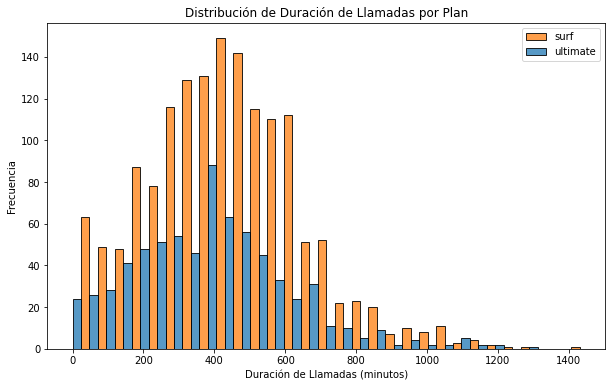

In [49]:
# Comparar la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.
plt.figure(figsize=(10, 6))
sns.histplot(data=user_mensual_data, x='duration', hue='plan', multiple='dodge', bins=30)
plt.title('Distribución de Duración de Llamadas por Plan')
plt.xlabel('Duración de Llamadas (minutos)')
plt.ylabel('Frecuencia')
plt.legend(labels=['surf', 'ultimate'])
plt.show()


Podemos ver que predominan las barras de color naranja (plan "ultimate") y son notablemente más altas en comparación con las barras azules (plan "surf"). La altura de las barras sugiere que la duración de las llamadas para el plan "ultimate" tiende a ser mayor en general. 

Además, observamos un rango de duración de llamadas común para ambos planes, que está entre 300 y 700 minutos, donde ambas barras alcanzan alturas considerables. Esto podría indicar que en ese rango de duración, los usuarios de ambos planes tienden a realizar llamadas con una duración más alta en ese lapso.

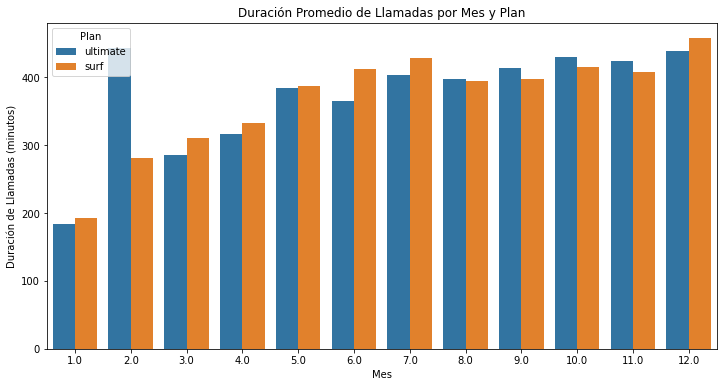

In [50]:
# Comparar el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.
plt.figure(figsize=(12, 6))
sns.barplot(data=user_mensual_data, x='month', y='minutes_used', hue='plan', ci=None)
plt.title('Duración Promedio de Llamadas por Mes y Plan')
plt.xlabel('Mes')
plt.ylabel('Duración de Llamadas (minutos)')
plt.legend(title='Plan')
plt.show()

En el gráfico de barras comparativo entre los planes "Ultimate" y "Surf" a lo largo de diferentes meses, se puede observar una interesante variación en la duración promedio de llamadas. 


Las barras del plan "Ultimate"superan a las de "Surf" en los meses 2, 9, 10 y 11. Esto sugiere que durante estos meses, los usuarios del plan "Ultimate" realizaron llamadas más prolongadas en comparación con los usuarios del plan "Surf". Sin embargo, en los restantes meses, las barras naranjas son más altas, indicando que en general los usuarios del plan "Surf" tendieron a tener una duración de llamadas mayor. 

Específicamente en el mes 2, se destaca un cambio notable, lo que podría indicar algún evento o promoción que atrajo a los usuarios del plan "Ultimate" a realizar llamadas más extensas. Podría verse si hubo eventos especiales, ofertas o cambios en el comportamiento de los usuarios que expliquen estos patrones.

In [51]:
# Calcula la media y la varianza de la duración mensual de llamadas.

# Filtrar el DataFrame para obtener solo las columnas relevantes
call_duration_by_plan_month = user_mensual_data[['plan', 'month', 'minutes_used']]

call_duration_stats = call_duration_by_plan_month.groupby(['plan', 'month'])['minutes_used'].agg(['mean', 'var']).reset_index()
call_duration_stats


,plan,month,mean,var
0,surf,1.0,192.840000,14795.440200
1,surf,2.0,280.851111,46959.219961
2,surf,3.0,310.970000,31821.317991
3,surf,4.0,332.380000,45615.666796
4,surf,5.0,387.108000,50778.127459
5,surf,6.0,411.450625,39424.054023
6,surf,7.0,428.060917,53364.540232
7,surf,8.0,394.474717,46639.240873
8,surf,9.0,397.133298,39785.302974
9,surf,10.0,414.435733,44103.681803


Los usuarios de los planes "surf" y "ultimate" muestran comportamientos de llamadas diferentes a lo largo del año. Los usuarios del plan "surf" tienden a tener una duración promedio de llamadas más estable, mientras que los usuarios del plan "ultimate" tienen fluctuaciones más marcadas en la duración de las llamadas, especialmente en los meses 2, 7 y 11. Esta información podría ser útil para tomar decisiones estratégicas en términos de ajustar los planes o dirigir las promociones en ciertos meses del año.

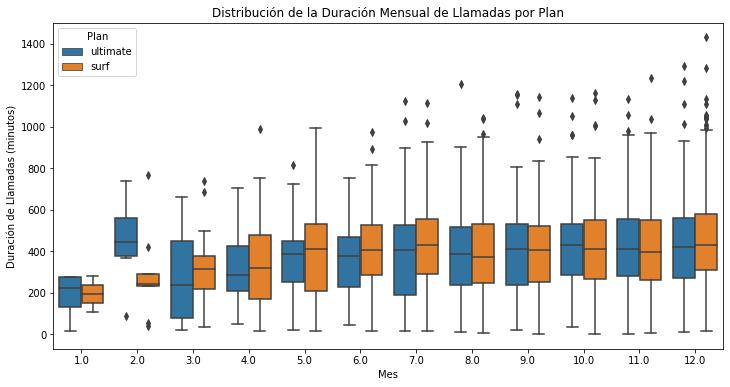

In [52]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_mensual_data, x='month', y='minutes_used', hue='plan')
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')
plt.xlabel('Mes')
plt.ylabel('Duración de Llamadas (minutos)')
plt.legend(title='Plan')
plt.show()

Es interesante observar que en los meses 1, 2, 3, 6, 7, 8, 9 y 12, las cajas azules (correspondientes al plan "ultimate") son más grandes que las naranjas (correspondientes al plan "surf"). Esto sugiere que en esos meses, los usuarios del plan "ultimate" tienden a tener una mayor variabilidad en la duración de sus llamadas en comparación con los usuarios del plan "surf". Además, en el mes 2, el plan "ultimate" parece tener una duración de llamada mucho más larga en comparación con el plan "surf", lo que puede indicar un comportamiento distinto en ese mes.

El tope máximo de las cajas por debajo de 600 minutos sugiere que la mayoría de las llamadas se encuentran dentro de ese rango de duración en general. Sin embargo, a partir del mes 9, notar que hay más puntos en la parte superior de las cajas indica que hay llamadas excepcionales o atípicas que exceden el rango de duración típico. Esto podría indicar situaciones específicas en esos meses en las que algunos usuarios, tanto de los planes "ultimate" como "surf", realizaron llamadas más largas de lo habitual.

**Conclusiones hasta ahora:**

- Los usuarios de ambos planes muestran diferencias en la distribución de la duración de las llamadas a lo largo del año. En varios meses, especialmente en el 2, 9, 10 y 11, los usuarios del plan "surf" realizaron llamadas más largas en comparación con los del plan "ultimate". Sin embargo, en otros meses, la duración de las llamadas de los usuarios del plan "ultimate" superó a las del plan "surf".

- Los usuarios del plan "surf" realizaron llamadas más largas en los primeros meses del año, con un pico en el mes 2, mientras que los usuarios del plan "ultimate" tuvieron una duración más uniforme a lo largo del año.

- El plan "ultimate" ofrece una mayor cantidad de minutos incluidos en comparación con el plan "surf", lo que podría explicar en parte la diferencia en la duración promedio de las llamadas. Los usuarios del plan "ultimate" tienden a tener llamadas más largas en general, pero también es importante considerar el número de minutos incluidos en cada plan al analizar este comportamiento.

### Mensajes

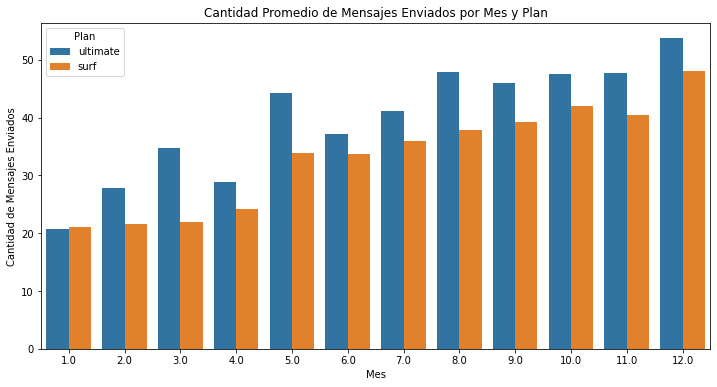

In [53]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
plt.figure(figsize=(12, 6))
sns.barplot(data=user_mensual_data, x='month', y='messages_sent', hue='plan', ci=None)
plt.title('Cantidad Promedio de Mensajes Enviados por Mes y Plan')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Mensajes Enviados')
plt.legend(title='Plan')
plt.show()

En cada uno de los meses (salvo enero por poco), la barra correspondiente al plan 'ultimate' supera en altura a la barra del plan 'surf'. Este patrón se mantuvo constante en todos los meses, lo que sugiere que los usuarios del plan 'ultimate' tienden a enviar más mensajes en promedio en comparación con los del plan 'surf'. Vemos también que el tope máximo de mensajes es de poco más de los 50.

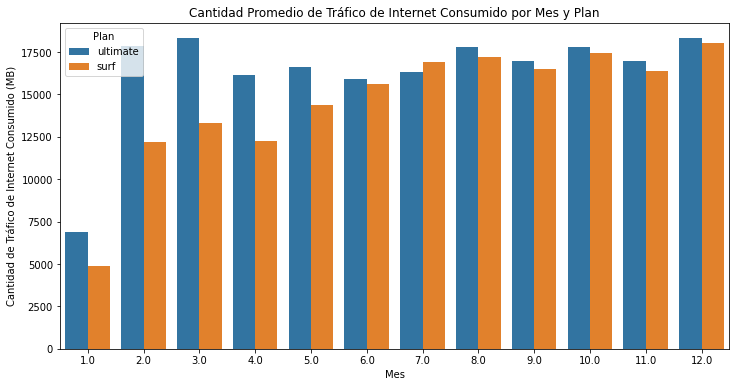

In [54]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan
plt.figure(figsize=(12, 6))
sns.barplot(data=user_mensual_data, x='month', y='mb_used', hue='plan', ci=None)
plt.title('Cantidad Promedio de Tráfico de Internet Consumido por Mes y Plan')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Tráfico de Internet Consumido (MB)')
plt.legend(title='Plan')
plt.show()


En este segundo cuadro, se observa una tendencia similar a la anterior, donde la barra de color azul, que corresponde al plan "Ultimate", es consistentemente más alta que la barra de color naranja, que representa el plan "Surf". Esta disparidad es más notable de enero a mayo, y aunque la diferencia se reduce en los meses siguientes, el plan "Ultimate" sigue consumiendo más tráfico de internet en general en comparación con el plan "Surf".

**Conclusiones hasta ahora:**

- Los usuarios del plan "Ultimate" muestran consistentemente un mayor promedio de mensajes enviados en comparación con los usuarios del plan "Surf" a lo largo de todos los meses analizados.

- Ambos planes experimentan un aumento en la cantidad de mensajes enviados a medida que avanza el año, alcanzando su punto máximo en los meses intermedios.

- La diferencia en el comportamiento de los usuarios en cuanto a mensajes entre los dos planes podría ser influenciada por factores como la cantidad de mensajes incluidos en cada plan y las preferencias individuales de los usuarios en relación con la comunicación por mensajes.

### Internet

Podemos analizar el consumo de los dato de acuerdo al plan de usuarios.

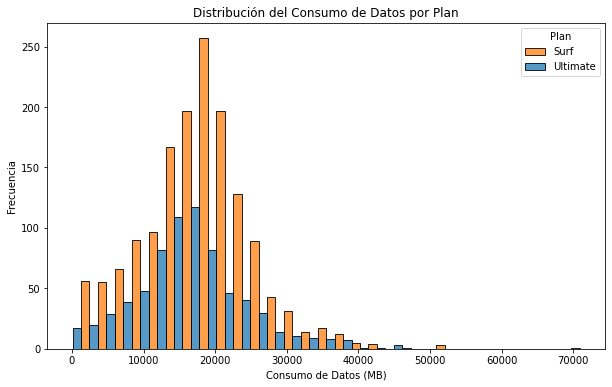

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(data=user_mensual_data, x='mb_used', hue='plan', multiple='dodge', bins=30)
plt.title('Distribución del Consumo de Datos por Plan')
plt.xlabel('Consumo de Datos (MB)')
plt.ylabel('Frecuencia')
plt.legend(title='Plan', labels=['Surf', 'Ultimate'])  # Aquí especificamos las etiquetas para la leyenda
plt.show()


Al analizar el gráfico de distribución del consumo de datos por plan, se observa que el plan "Surf" tiende a tener una mayor proporción de usuarios con un consumo de datos más alto en comparación con el plan "Ultimate". Las barras más altas y frecuentes en el rango de valores indican que un número significativo de usuarios de "Surf" tienden a utilizar más datos en comparación con los usuarios de "Ultimate". Sin embargo, ambos planes muestran cierta cantidad de usuarios con consumos bajos y altos. Esta diferencia en los patrones de consumo podría indicar que el plan "Surf" atrae a usuarios con necesidades de datos más elevadas en general.

Analizaremos la tendencia del consumo promedio de datos a lo largo del tiempo en función de la fecha de registro de los usuarios. 

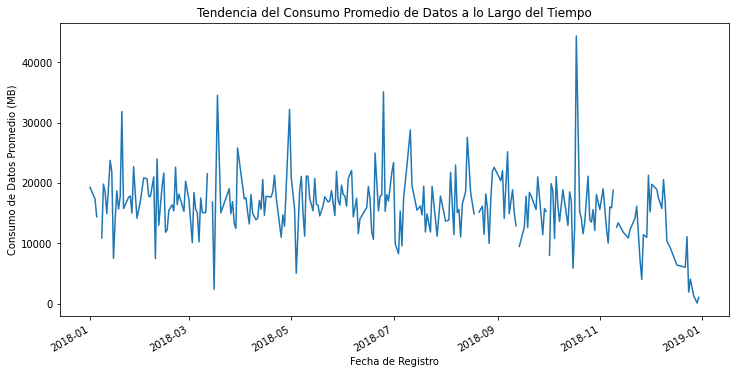

In [56]:
# Analiza la tendencia del consumo promedio de datos a lo largo del tiempo
data_usage_over_time = user_mensual_data.groupby('reg_date')['mb_used'].mean()

plt.figure(figsize=(12, 6))
data_usage_over_time.plot()
plt.title('Tendencia del Consumo Promedio de Datos a lo Largo del Tiempo')
plt.xlabel('Fecha de Registro')
plt.ylabel('Consumo de Datos Promedio (MB)')
plt.show()


Podemos ver una caída considerable desde finales del 2018 y comienzos del 2019.

**Conclusiones hasta el momento:**

- Observamos una caída significativa en el consumo promedio de datos desde finales de 2018 hasta principios de 2019. Esto podría sugerir un cambio en el comportamiento de los usuarios, posiblemente influenciado por cambios en las preferencias de uso de aplicaciones o servicios.

- Al comparar el tráfico de internet consumido por mes para cada plan, observamos que se destaca una disparidad notable entre los comportamientos de los usuarios de los planes "Surf" y "Ultimate". El plan "Surf" presenta una concentración significativa de usuarios con un consumo de datos más alto en comparación con el plan "Ultimate". 

## Ingreso

[Del mismo modo en que has estudiado el comportamiento del usuario, es decir, estadísticamente, describe el ingreso entre los planes.]

In [57]:
# Calcula la suma de ingresos por plan
income_by_plan = user_mensual_data.groupby('plan')['monthly_income'].sum().reset_index()

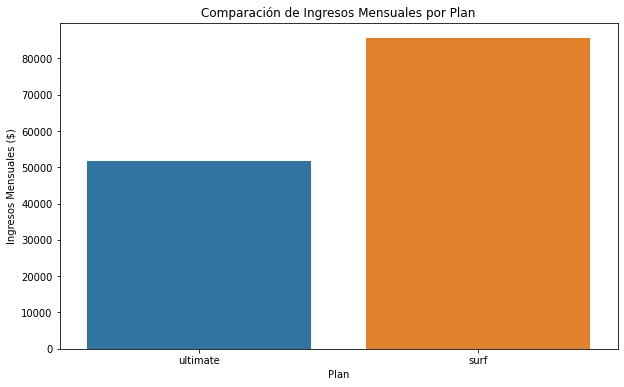

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(data=income_by_plan, x='plan', y='monthly_income', ci=None, order=['ultimate', 'surf'])

# Configura el título y etiquetas de los ejes
plt.title('Comparación de Ingresos Mensuales por Plan')
plt.xlabel('Plan')
plt.ylabel('Ingresos Mensuales ($)')
plt.xticks(rotation=0)

# Muestra el gráfico
plt.show()

Al analizar los datos de ingresos mensuales entre los planes "Surf" y "Ultimate", se observa que la barra correspondiente al plan "Ultimate" es más pequeña en comparación con la del plan "Surf". A pesar de que el plan "Ultimate" tiene un costo base más alto, esto sugiere que los usuarios de ese plan podrían estar generando ingresos menores en promedio en comparación con los usuarios del plan "Surf". Las diferencias en ingresos podrían estar relacionadas con el comportamiento de consumo de servicios adicionales, como datos, mensajes y minutos de llamadas.

## Probar las hipótesis estadísticas.

**Hipótesis Nula**: No hay diferencia significativa en el ingreso promedio entre los usuarios de los planes "Ultimate" y "Surf".

**Hipótesis Alternativa**: Existe una diferencia significativa en el ingreso promedio entre los usuarios de los planes "Ultimate" y "Surf".

In [59]:
# Obtén los ingresos de los usuarios de los planes "Ultimate" y "Surf"
ultimate_income = user_mensual_data[user_mensual_data['plan'] == 'ultimate']['monthly_income']
surf_income = user_mensual_data[user_mensual_data['plan'] == 'surf']['monthly_income']

# Definición de las hipótesis
# H0: No hay diferencia en el ingreso promedio entre los planes "Ultimate" y "Surf"
# H1: Hay una diferencia en el ingreso promedio entre los planes "Ultimate" y "Surf"

# Nivel de significancia (alfa)
alpha = 0.05

# Prueba de hipótesis utilizando la Prueba t de Student
t_statistic, p_value = ttest_ind(ultimate_income, surf_income, equal_var=False)

# Comparación con el valor alfa
if p_value < alpha:
    print("Rechazamos la hipótesis nula")
    print("Hay evidencia estadística de una diferencia en el ingreso promedio entre los planes.")
else:
    print("No rechazamos la hipótesis nula")
    print("No hay suficiente evidencia estadística para afirmar que hay una diferencia en el ingreso promedio.")

    print("No hay suficiente evidencia estadística para afirmar que hay una diferencia en el ingreso promedio.")


Rechazamos la hipótesis nula
Hay evidencia estadística de una diferencia en el ingreso promedio entre los planes.


La prueba de hipótesis indica que hay una diferencia estadísticamente significativa en el ingreso promedio entre los planes "Ultimate" y "Surf". Esta conclusión se basa en el valor del p-value que obtuviste al compararlo con el nivel de significancia (alfa) que se ha elegido. Rechazar la hipótesis nula sugiere que la diferencia observada en los ingresos promedio no es simplemente el resultado del azar, sino que es representativa de una diferencia real entre los planes.

**Hipótesis Nula**: El ingreso promedio de los usuarios del área NY-NJ es igual al ingreso promedio de los usuarios de otras regiones.

**Hipótesis Alternativa**: El ingreso promedio de los usuarios del área NY-NJ es diferente al ingreso promedio de los usuarios de otras regiones.

In [60]:

# Filtra los datos para usuarios del área NY-NJ y usuarios de otras regiones
ny_nj_income = user_mensual_data[user_mensual_data['city'].str.contains('NY-NJ')]['monthly_income']
other_regions_income = user_mensual_data[~user_mensual_data['city'].str.contains('NY-NJ')]['monthly_income']

# Realiza la prueba t de dos muestras independientes
t_statistic, p_value = stats.ttest_ind(ny_nj_income, other_regions_income, equal_var=False)

# Nivel de significancia
alpha = 0.05

# Compara el p-valor con el nivel de significancia
if p_value < alpha:
    conclusion = "Rechazamos la hipótesis nula"
else:
    conclusion = "No hay suficiente evidencia para rechazar la hipótesis nula"


print(f"Estadístico : {t_statistic}")
print(f"P-valor: {p_value}")
print(conclusion)



Estadístico : -2.703841477347265
P-valor: 0.007065724495019462
Rechazamos la hipótesis nula


Hay evidencia estadística para afirmar que el ingreso promedio de los usuarios del área NY-NJ es significativamente diferente al ingreso promedio de los usuarios de otras regiones.

## Conclusión general

En este proyecto, exploramos y analizamos un conjunto de datos que contenía información sobre los usuarios de una compañía de telecomunicaciones. Nuestro objetivo fue comprender el comportamiento de los usuarios en relación con sus planes de llamadas y su consumo de datos, así como probar algunas hipótesis estadísticas. A lo largo del análisis, tomamos decisiones fundamentales para procesar los datos y obtener insights significativos. 

- Dividir a los usuarios en dos planes distintos, "Surf" y "Ultimate", nos permitió identificar diferencias notables en el comportamiento de los usuarios. Los usuarios de "Surf" tienden a tener un consumo de datos más alto en comparación con los usuarios de "Ultimate".

- Observamos que el número de minutos utilizados varía a lo largo del año y que los usuarios de "Ultimate" hacen más llamadas en general. Sin embargo, ambos grupos de usuarios se mantienen dentro de los límites incluidos en sus respectivos planes.

- Los usuarios de "Surf" tienden a enviar más mensajes en promedio que los usuarios de "Ultimate", pero en ambos casos, el volumen de mensajes es bajo en comparación con las llamadas y el uso de datos.

- Los usuarios de "Surf" muestran un patrón de consumo de datos más alto y amplio en comparación con los usuarios de "Ultimate". La distribución de consumo de datos se inclina hacia valores más altos en "Surf", indicando una mayor necesidad de datos en este plan.

- Descubrimos que, aunque el plan "Surf" tiene más usuarios, el plan "Ultimate" genera más ingresos en promedio debido a su mayor tarifa mensual y tarifas adicionales.

- Finalmente, utilizamos pruebas estadísticas para confirmar nuestras suposiciones. Encontramos evidencia suficiente para rechazar la hipótesis nula en ambos casos: la diferencia en ingresos promedio entre los planes y la diferencia en ingresos promedio entre usuarios del área NY-NJ y otras regiones.